In [3]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd


# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

In [4]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

#### Bring in Global Temp By State Data

In [5]:
states = pd.read_csv('GlobalLandTemperaturesByState.csv')

In [6]:
states.Country.unique()

array(['Brazil', 'Russia', 'United States', 'Canada', 'India', 'China',
       'Australia'], dtype=object)

#### Prep Data

In [7]:
# Isolate Data by Country(United States) & State(Texas)
df = states[states.Country=='United States'][states.State=='Texas']

In [8]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
549727,1820-01-01,4.489,3.369,Texas,United States
549728,1820-02-01,9.081,2.873,Texas,United States
549729,1820-03-01,12.657,2.423,Texas,United States
549730,1820-04-01,19.215,2.501,Texas,United States
549731,1820-05-01,22.577,2.495,Texas,United States


In [9]:
# check to see if dt is Datetime
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 549727 to 552051
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2325 non-null   object 
 1   AverageTemperature             2325 non-null   float64
 2   AverageTemperatureUncertainty  2325 non-null   float64
 3   State                          2325 non-null   object 
 4   Country                        2325 non-null   object 
dtypes: float64(2), object(3)
memory usage: 109.0+ KB


In [10]:
# convert to DateTime and reset index
df.dt = pd.to_datetime(df.dt)
df = df.set_index('dt').sort_index()

In [11]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
1820-01-01,4.489,3.369,Texas,United States
1820-02-01,9.081,2.873,Texas,United States
1820-03-01,12.657,2.423,Texas,United States
1820-04-01,19.215,2.501,Texas,United States
1820-05-01,22.577,2.495,Texas,United States


In [12]:
# Convert Celcius to Fahrenheit
df = df.assign(AvgTempF = lambda x: (9/5)*x['AverageTemperature']+32)

In [13]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty,State,Country,AvgTempF
dt,,,,,
1820-01-01,4.489,3.369,Texas,United States,40.0802
1820-02-01,9.081,2.873,Texas,United States,48.3458
1820-03-01,12.657,2.423,Texas,United States,54.7826
1820-04-01,19.215,2.501,Texas,United States,66.5870
1820-05-01,22.577,2.495,Texas,United States,72.6386


In [14]:
# drop duplicate column
df = df.drop(columns=('AverageTemperatureUncertainty'))

In [15]:
df.head()

,AverageTemperature,State,Country,AvgTempF
dt,,,,
1820-01-01,4.489,Texas,United States,40.0802
1820-02-01,9.081,Texas,United States,48.3458
1820-03-01,12.657,Texas,United States,54.7826
1820-04-01,19.215,Texas,United States,66.5870
1820-05-01,22.577,Texas,United States,72.6386


In [16]:
# check for any null values
df.isnull().sum()

AverageTemperature    0
State                 0
Country               0
AvgTempF              0
dtype: int64

In [17]:
df = df.resample('m')['AvgTempF'].mean()

In [18]:
df = pd.DataFrame(df)

In [19]:
df.head()

,AvgTempF
dt,
1820-01-31,40.0802
1820-02-29,48.3458
1820-03-31,54.7826
1820-04-30,66.5870
1820-05-31,72.6386


***
Prepare Notes:
* I chose the State Temp Data set and focused on Texas in the United States
* I converted temp into Fahrenheit b/c the association easier for me
* Dropped all columns except for my target AvgTempF
* Confirmed no nulls in my data set
* resampled by Month
***

#### Split Data

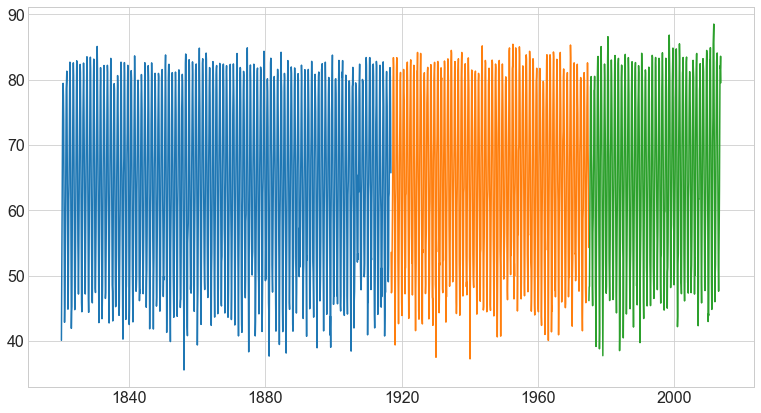

In [20]:
train_size = int(len(df) * .50)
validate_size = int(len(df) * .30)
test_size = int(len(df) * .20)

validate_end_index = train_size + validate_size

train = df[:train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:] 

plt.plot(train.index, train.AvgTempF)
plt.plot(validate.index, validate.AvgTempF)
plt.plot(test.index, test.AvgTempF)

In [21]:
# confirm proper splits
print(train.tail(1))
print(validate.head(1))
print(validate.tail(1))
print(test.head(1))

            AvgTempF
dt                  
1916-10-31    65.741
            AvgTempF
dt                  
1916-11-30    53.555
            AvgTempF
dt                  
1974-11-30   54.3056
            AvgTempF
dt                  
1974-12-31    46.166


***
Split Notes:
* I decided to use the % split since I decided to use the entire data set
* I evaluated my split and verified that train, validate, test all begin and end on subsequent timeframes (monthly in this case)
***

#### Explore

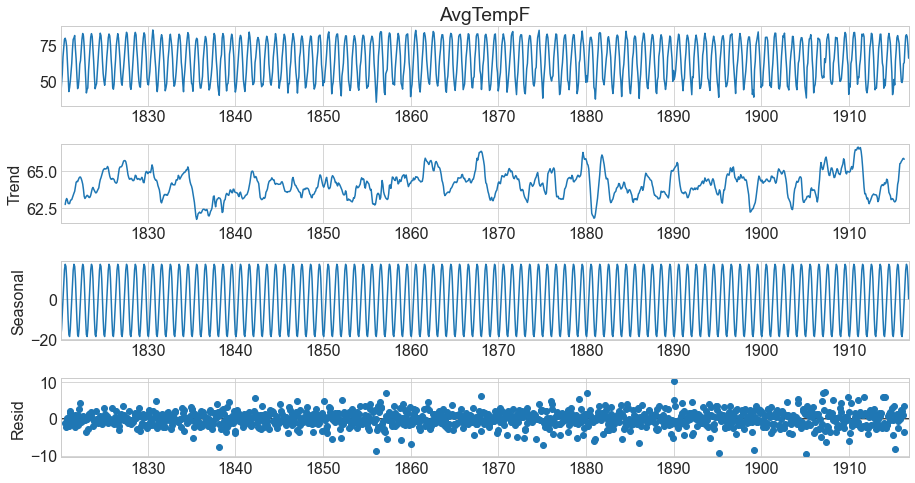

In [22]:
# Monthly timeframe
sm.tsa.seasonal_decompose(train.AvgTempF).plot()
plt.show()

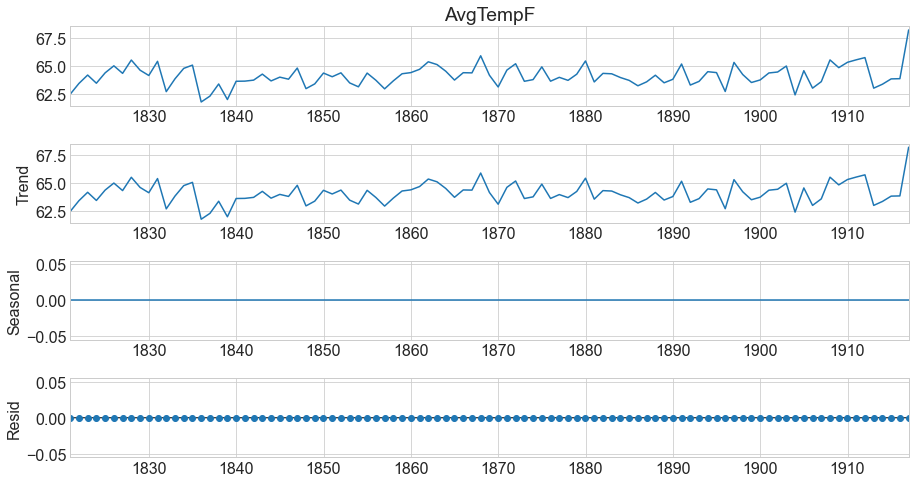

In [23]:
# Annual timeframe
sm.tsa.seasonal_decompose(train.AvgTempF.resample('Y').mean()).plot()
plt.show()

***

Initial Explore Notes:
* Quick and dirty seasonal decomposition shows no clear trend in the Monthly timeframe but very well defined seasonality while the Annual timeframe shows some upward trend (acceleration shorlty after 1910) but no seasonality
* Assumption is that my projections would be best served by smoothing out the Monthly data over a longer time horizon
***

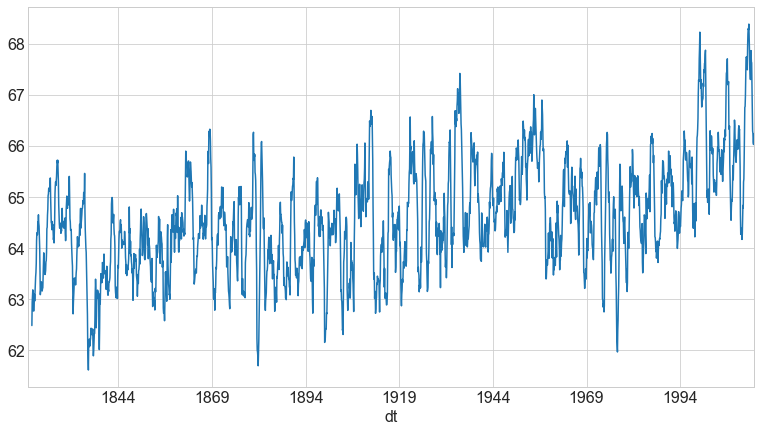

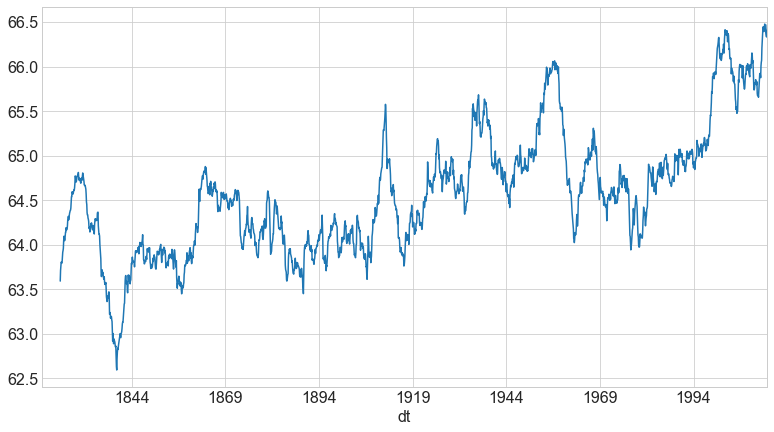

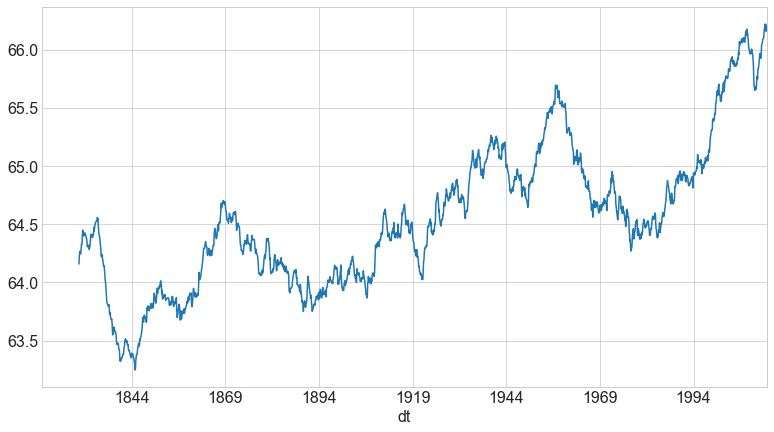

In [28]:
# visualize entire data using 1, 5 & 10yr or 12, 60 & 120month rolling averages
horizon = [12, 60, 120]
for h in horizon:
    df.AvgTempF.resample('M').mean().rolling(h).mean().plot()
    plt.show()

***
* After smoothing the data out, there is a clear uptrend in the data 
* However, there are also multiple sub trends that could skew modeling errors depending on where the Train, Validate, Test breaks lie
    * Fortunately, it appears as though the 1916 & 1974 breaks appear to line up roughly well with what looks to be a repetitive cyclical pattern.  If this were crypto I'd say they were fractals in a 5 wave Elliot motive impulse (looking at the 120 month rolling avg)
***

#### Setup

In [73]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [71]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [88]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [89]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [90]:
eval_df

,model_type,target_var,rmse


#### Forecast

Forecasting methodologies: 

1. Last Observed Value: The future will look like the now
2. Simple Average: The future will look, on average, like history. 
3. Moving Average: The future will look, on average, like recent history. 
4. Holt's Linear Trend
5. Previous Cycle

##### Last Observed Value

In [65]:
# take the last temp and assign to variable
temp = round(train['AvgTempF'][-1:][0], 2)
temp

65.74

In [78]:
# Make predictions
yhat_df = pd.DataFrame({'AvgTempF': [temp]}, 
                      index = validate.index)

yhat_df.head()

,AvgTempF
dt,
1916-11-30,65.74
1916-12-31,65.74
1917-01-31,65.74
1917-02-28,65.74
1917-03-31,65.74


In [67]:
# Check to see all predicted values are same
yhat_df.nunique()

AvgTempF    1
dtype: int64

AvgTempF -- RMSE: 13


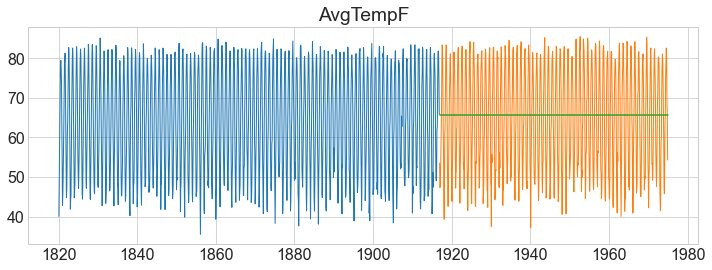

In [74]:
# plot
plot_and_eval('AvgTempF')

In [91]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = 'AvgTempF')
eval_df

,model_type,target_var,rmse
0,last_observed_value,AvgTempF,13.0


##### Simple Average

In [107]:
# compute simple average
temp = round(train['AvgTempF'].mean(), 2)
temp 

64.09

In [108]:
# Make predictions
yhat_df = pd.DataFrame({'AvgTempF': [temp]}, 
                      index = validate.index)

yhat_df.head()

,AvgTempF
dt,
1916-11-30,64.09
1916-12-31,64.09
1917-01-31,64.09
1917-02-28,64.09
1917-03-31,64.09


In [109]:
# Check to see all predicted values are same
yhat_df.nunique()

AvgTempF    1
dtype: int64

AvgTempF -- RMSE: 13


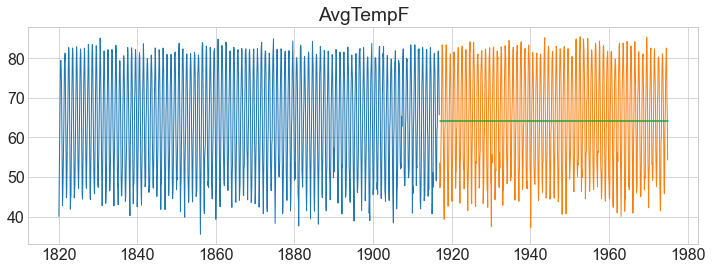

In [110]:
# plot
plot_and_eval('AvgTempF')

eval_df = append_eval_df(model_type = 'simple_average', 
                             target_var = 'AvgTempF')
eval_df

##### Moving Average (multiple)

In [112]:
def make_predictions():
    yhat_df = pd.DataFrame({'AvgTempF': [temp]},
                          index=validate.index)
    return yhat_df

In [113]:
periods = [12, 60, 120] 

for p in periods: 
    temp = round(train['AvgTempF'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'm_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [114]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,AvgTempF,13.0
1,simple_average,AvgTempF,13.0
2,simple_average,AvgTempF,13.0
3,12m_moving_avg,AvgTempF,13.0
4,60m_moving_avg,AvgTempF,13.0
5,120m_moving_avg,AvgTempF,13.0
